In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np

from datetime import date
from datetime import timedelta
from sklearn import preprocessing

module_path = os.path.abspath("/seq/vgb/bryc/projects/pheno")
sys.path.insert(0, module_path)

import pheno
from pheno import PhenoDB

In [2]:
age_map = {
    '2018-12-08': np.nan,
    '2016-10-30': np.nan,
    '2017-03-03': np.nan,
    '8-10': "9",
    'born about 2011' : np.nan,
    '9 years': "9",
    '2017-02-16' : np.nan,
    '3 1/2': "3.5",
    '2017-06-24' : np.nan,
    '1 year': "1",
    '12-13 years old': "12.5", 
    '2ish': "2", 
    '2 1/2': "2.5",
    '1-2 yrs': "1.5",
    '8 years': "8",
    '4-5 years': "4.5",
    '2017-11-26' : np.nan,
    '2009-09-01' : np.nan, 
    '2016-01-01' : np.nan,
    '2011-05-29' : np.nan,
    '2012-01-05' : np.nan,
    '2013-03-01' : np.nan,
    '3.5 yrs': "3.5",
    '5 months': "0.42",
    'about 9': "9", 
    '5 ?': "5",
    '12 weeks':"0.25" ,
    '5-6': "5.5", 
    '3 years': "3", 
    '4;&#39;': "4",
    '10months': "0.83", 
    '7-10': "8",
    '011 months': "0.92",
    '23 months': "1.92",
    '123 months': np.nan,
    '1 yr, 4 mos':"1.33", 
    '5m': "0.42", 
    '9 months' : "0.75",
    '6th': np.nan, 
    '6 months': "0.5",
    '1year':"1.0",
       '1.5 yr': "1.5",
    '11?': "11",
    '10 mos': "0.83",
    '11 months': "0.92",
    'about 15': "15", 
    '19 weeks': "0.4" ,
    '20 months': "1.67",
    '3ish': "3", 
    '08': np.nan,
    '13ish': "13",
    '3.5 months':"0.29",
    '5 mo': "0.42",
    '3 yr': "3",
    '~10 mo.':"0.83",
    '15?': "15",
    '3 +/-': "3",
    '10 months': "0.83",
    'About 7 years, 10 months': "7.83",
    '9+ years': "9",
    '~5': "5",
    '12 months': "1.0",
    'approx 7 years': "7",
    '9 mos': "0.75",
    '16mo': "1.33",
    '06 months': "0.5",
    '7mos.': "0.58",
    '9mo': "0.75",
    '2-ish': "2", '55':np.nan,
    '16 months': "1.33",
    '20 mos': "1.67", 
    '?':np.nan,
    '07 months':"0.58",
    '66':np.nan, 
    '10-12': "11",
    '6 mo': "0.5",
    '6 + / -':"6",
    'NOT SURE 300 YEARS REINCARNATED':np.nan,
    '6+9mos': "6.82",
    '77': np.nan,
    '15ish': "15",
    '8?': "8",
    '8 months': "0.67",
    '03': "0.3",
    '33': np.nan,
    '22': np.nan, 
    '1y7mos': "1.58",
    '9-10 yo': "9.5",
    '10?': "10",
    '7 weeks': "0.15",
    '1 1/2': "1.5",
    '5 1/2': "5.5",
    '4y/5m': "4.42",
    '8mo': "0.67",
    '9 weeks': "0.19",
    '01': np.nan,
    '9mos': "0.75",
    '6mo': "0.5",
    '07': "7",
    '6 YO': "6",
    '5 mos': "0.42",
    '2014': np.nan,
    '7 1/2 yrs old': "7.5",
    "5 or 6 years": "5.5",
    "2 1/2 years": "2.5",
    "5 to 7 years old": "6.0",
    "6 or 7 years": "6.5"
}

In [3]:
cache_dir = "/seq/vgb/bryc/data/darwins_dogs/2024-09-23_cache"
ph = PhenoDB(cache_dir)

INFO:pheno.phenodb:Reading in csv file of survey data
/seq/vgb/bryc/projects/pheno/pheno/phenodb.py:34: DtypeWarning: Columns (8,13,28,32,41,43,44,52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dogs = pd.read_csv(os.path.join(cache_directory, "dogs.csv"))
INFO:pheno.phenodb:Reading in csv file of breed ancestry estimates...
INFO:pheno.phenodb:Creating numerical matrix from survey data


In [4]:
# Find the SRA uploaded dog IDs and subset to those
SRA_file = "/seq/vgb/rawData/gencove/DarwinsArk/fastq/SRA/sampleIDs.txt"
filenames = pd.read_csv(SRA_file, header=None)
filenames[['DA', 'dogID', 'barcode']] = filenames[0].str.split('_', n=2, expand=True)
filenames['dogID'] = filenames.dogID.astype(int)
# Fix two incorrect SRA file dogIDs (filenames were incorrect, dog is correct in spreadsheet/data):
filenames["dogID"] = filenames["dogID"].replace({26971: 26961, 12450:12350})
SRA_2024 = pd.read_csv("/seq/vgb/rawData/gencove/DarwinsArk/fastq/2024-08-22_SRA/files/2024-08-22_SRA.csv")
all_SRA_dogs = (SRA_2024['darwinsark_id'].tolist() + filenames['dogID'].tolist())


In [5]:
print(len(all_SRA_dogs))

3313


In [6]:
# Cleanup of sex, neuter, purebred, and age
subset = ph.dogs[ph.dogs.id.isin(all_SRA_dogs)].copy()
subset["sex"] = subset['sex'].replace({"Male": "male", "Female": "female"})
subset["neutered"] = subset['neutered'].replace({"Yes": "yes", "No": "no"})
subset["purebred"] = subset["purebred"].replace({"1": "yes", "0": "no", "-1": np.NaN})
subset["age"] = subset["age"].replace(age_map)
# Remove non-plausible ages
subset.loc[subset.age_norm > 25, "age_norm"] = np.nan

### Get `age_composed` which will combine the best information across columns

In [7]:
subset['creation_date']= pd.to_datetime(subset['creation_date'])
subset['birthday']= pd.to_datetime(subset['birthday'])
subset["deceased_date"] = pd.to_datetime(subset['deceased'], unit='s')

In [8]:
subset["inferred_age"] = (subset['creation_date'] - subset['birthday']) / timedelta(days=365)
subset["numeric_age"] = pd.to_numeric(subset["age"], errors='coerce')
subset["age_at_death"] = (subset['deceased_date'] - subset['birthday']) / timedelta(days=365)
subset["age_composed"] = subset["age_norm"].fillna(subset["inferred_age"])
subset["age_composed"] = subset["age_composed"].fillna(subset["numeric_age"])

In [9]:
age_cols = ["id", "age", "creation_date", "birthday", "age_composed", "age_norm", "birthday_historical", "inferred_age", "numeric_age", "age_at_death"]
subset[subset.age_norm - subset.inferred_age > 0.5][age_cols]

# Overwrite with the manually entered age because there is a typo in the birthyear
subset.loc[subset.id == 2144, "age_composed"] = 4.0
subset.loc[subset.id == 11503, "age_composed"] = 3.0

### Get breed information

In [10]:
id_to_breed = dict(zip(ph.breeds.id, ph.breeds.breed_print))
for column in ['breed1_id','breed2_id', 'breed3_id']:
    subset[column] = subset[column].replace(id_to_breed)
subset[['breed1_id','breed2_id', 'breed3_id']]

,breed1_id,breed2_id,breed3_id
27,NaN,NaN,NaN
45,NaN,NaN,NaN
92,NaN,NaN,NaN
95,NaN,NaN,NaN
97,NaN,NaN,NaN
...,...,...,...
44344,Rough Collie,NaN,NaN
44404,Beagle,American Foxhound,NaN
44416,NaN,NaN,NaN
44440,Labrador Retriever,NaN,NaN


In [11]:
# Get combined breed information between older freetext data and recent ID columns
subset['breed1'] = subset['breed1'].fillna(subset['breed1_id'])
subset['breed2'] = subset['breed2'].fillna(subset['breed2_id'])
subset['breed3'] = subset['breed3'].fillna(subset['breed3_id'])

# Clean up messy manually-entered breed names
manual_fixes = {"beagle \"plus\" ... tri-color white + liver + brown; brown \"freckles\" on white legs": "Beagle",
               "sato": "Sato",
               "miniature australian shepherd": "Miniature Australian Shepherd",
               "Black mouth curr": "Black Mouth Cur",
               "wire haired fox terrier": "Wire Fox Terrier",
               "Wire Haired Fox Terrier": "Wire Fox Terrier",
               "Congo dog": "Basenji",
               "Swiss White Shepherd":"White Swiss Shepherd Dog",
               "Hamiltonstovare": "Hamilton Hound",
               "labradoodle": "Labradoodle",
               "50% Chihuahua ":"Chihuahua",
               "50% Australian Kelpie ": "Australian Kelpie",
               "Akbash Dog": "Akbash",
               "Berger Blanc Suisse": "White Swiss Shepherd Dog",
               'German Munsterhund': "Small Münsterländer",
               "Xoloitzcuintli": "Mexican hairless dog",
               "Black & Tan Coonhound": "Black and Tan Coonhound",
               "Louisiana Catahoula Leopard Dog": "Catahoula Leopard Dog",
               "German Shepherd Dog (50%)": 'German Shepherd Dog',
               "windsprite": "Silken Windsprite",
               "Golden Retriever?": "Golden Retriever",
               "miniature dachshund": "Miniature Dachshund",
               "American Black and Tan Coonhound": "Black and Tan Coonhound",
               "Plott": "Plott Hound",
               "Red Heeler": "Australian Cattle Dog",
               "Flat-coated Retrievers": "Flat-Coated Retrievers",
               "Blue Heeler": "Australian Cattle Dog",
               "mixed":np.nan,
                "Mix": np.nan,
               "tennesee brindle mountain cur": "Treeing Tennessee Brindle",
               "Chihuahua (Long": "Chihuahua (Long Coat)",
               " Boarder Collie ": "Border Collie",
               "25% GSD": "German Shepherd",
               "25% Chow": "Chow Chow",
               "larger hound": np.nan,
                "australian kelpie": "Australian Kelpie",
               "catahoula leopard dog": "Catahoula Leopard Dog"}
subset["breed1"]= subset.breed1.replace(manual_fixes)
subset["breed2"]= subset.breed2.replace(manual_fixes)

In [12]:
# Use breed2 results if breed1 is missing
subset['breed1'] = subset['breed1'].fillna(subset['breed2'])
subset.loc[subset.breed1 == subset.breed2,'breed2'] = np.nan

### Get ancestry results for all dogs

In [13]:
ancestry = pd.read_csv(os.path.join(cache_dir, "dog_breed.csv"))
ancestry = ancestry[ancestry.version == "v2"]
ancestry["breed"] = ancestry["breed"].replace(id_to_breed)
samples  = pd.read_csv(os.path.join(cache_dir, "samples.csv"))
non_na_samples = samples[~samples.dog.isna()]
barcode_to_dog = dict(zip(non_na_samples.barcode, non_na_samples.dog))
dog_to_barcode = {v: k for k, v in barcode_to_dog.items()}
ancestry["id"] = ancestry["barcode"].map(barcode_to_dog)
with_ancestry = ancestry.id.unique()

In [14]:
missing = [dog  for dog in subset.id if dog not in with_ancestry]
print(len(missing))

136


In [15]:
barcode_fixes = {}
barcodes_with_anc_results = ancestry.barcode.unique()

for dog in missing:
    try:
        barcode = dog_to_barcode[dog]
        if (barcode + "-a") in barcodes_with_anc_results:
            barcode_fixes[barcode + "-a"] = dog
        else:
            print("No results for barcode", barcode, "and dog", dog)
    except:
        print("dog ", dog, " not found in samples table")

ancestry["id"] = ancestry["id"].fillna(ancestry["barcode"].map(barcode_fixes))

No results for barcode 31001602030996 and dog 1477
No results for barcode 31001602110698 and dog 1826
No results for barcode 31001602031982 and dog 4543
No results for barcode 31001705283021 and dog 6406
No results for barcode 31001602110094 and dog 10316
No results for barcode 31001602110825 and dog 10355
No results for barcode 31001602110843 and dog 10356
dog  12188  not found in samples table


In [16]:
# Side bar: let's make a file to address these 128 mismapped dogs and give them breed results
import time

unix_timestamp = int(time.time()) 
mismapped_barcode_file = "/seq/vgb/rawData/gencove/raw/doc/2024-09-30_Kasia_mismapped_barcode_fixes.txt"
with open(mismapped_barcode_file, "w") as file1:
    for barcode, dog in barcode_fixes.items():
        # Writing data to a file
        file1.write(f"insert into samples (time,type,barcode,dog,location1,project) values ({unix_timestamp},1,\"{barcode}\",{dog},17,1);\n")


In [17]:
with_ancestry = ancestry.id.unique()
still_missing = [dog  for dog in subset.id if dog not in with_ancestry]

print(len(still_missing))

8


In [18]:
to_fix = {}
for dog in filenames[filenames.dogID.isin(still_missing)].dogID.values:
    try:
        bar = dog_to_barcode[dog]
        to_fix[dog] = bar
    except:
        print("no barcode for dog ", dog)

no barcode for dog  12188


In [19]:
dedup = ancestry.drop_duplicates(keep='last', subset = ["id", "breed"])
df = dedup.pivot(index='id', columns='breed', values='percent').reset_index()
ancestries = df[df.id.isin(subset.id)]

### Prepare merged dataframe

In [20]:
useful_cols = ['id',
 'name',
 'sex',
 'neutered',
 'creation_date',
 'age_composed',
 'age',
 'age_norm',
 'numeric_age',
 'inferred_age',
 'dob_known',
 'birthday',
 'birthday_historical',
 'breed1',
 'breed2',
 'breed3',
 'purebred',
 'deceased_date',
 'age_at_death']

In [21]:
subset[useful_cols] 

,id,name,sex,neutered,creation_date,age_composed,age,age_norm,numeric_age,inferred_age,dob_known,birthday,birthday_historical,breed1,breed2,breed3,purebred,deceased_date,age_at_death
27,28,Calliope,female,yes,NaT,1.684070,1.67,1.68407,1.67,NaN,0,2014-02-01,2014 (Jan or Feb),NaN,NaN,NaN,NaN,NaT,NaN
45,46,Phil,male,yes,NaT,1.521980,2014-04-01,1.52198,NaN,NaN,0,2014-04-01,NaN,Dalmatian,American Pit Bull Terrier,NaN,NaN,NaT,NaN
92,95,Shandy,female,yes,NaT,7.535710,2008-04-06,7.53571,NaN,NaN,0,2008-04-06,NaN,German Shepherd Dog,NaN,NaN,yes,2022-04-30 11:02:19,14.075233
95,98,Jamie,female,yes,NaT,13.818700,13 yr old,13.81870,NaN,NaN,0,2002-01-01,2002,NaN,NaN,NaN,NaN,NaT,NaN
97,100,Lola,female,yes,NaT,4.513740,7,4.51374,7.00,NaN,0,2011-04-12,2011-04-12,Standard Poodle,NaN,NaN,yes,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44344,44928,Finley,male,yes,2024-06-30 12:28:34,10.784986,10,NaN,10.00,10.784986,0,2013-09-20,NaN,Rough Collie,NaN,NaN,yes,NaT,NaN
44404,44988,Buttons,female,yes,2024-06-30 21:33:44,5.000000,5,NaN,5.00,NaN,0,NaT,NaN,Beagle,American Foxhound,NaN,no,NaT,NaN
44416,45000,Frida,female,yes,2024-07-01 01:08:38,0.276843,0,NaN,0.00,0.276843,0,2024-03-22,NaN,NaN,NaN,NaN,no,NaT,NaN
44440,45024,Dublin,male,yes,2024-07-01 13:20:03,5.000000,5,NaN,5.00,NaN,1,NaT,NaN,Labrador Retriever,NaN,NaN,no,NaT,NaN


In [22]:
# merge phenotypes with ancestries
ancestries = ancestries.fillna(0)
phenotypes = pd.merge(subset[useful_cols], ancestries, how = "outer", on="id")

In [23]:
phenotypes

,id,name,sex,neutered,creation_date,age_composed,age,age_norm,numeric_age,inferred_age,...,Village Dog (China),Village Dog (Nigeria),Village Dog (Vietnam),Vizsla,Weimaraner,West Highland White Terrier,Whippet,Wire Fox Terrier,Wirehaired Pointing Griffon,Yorkshire Terrier
0,28,Calliope,female,yes,NaT,1.684070,1.67,1.68407,1.67,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.016071
1,46,Phil,male,yes,NaT,1.521980,2014-04-01,1.52198,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.015404
2,95,Shandy,female,yes,NaT,7.535710,2008-04-06,7.53571,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,98,Jamie,female,yes,NaT,13.818700,13 yr old,13.81870,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.012013,0.0,0.0,0.027555
4,100,Lola,female,yes,NaT,4.513740,7,4.51374,7.00,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3290,44928,Finley,male,yes,2024-06-30 12:28:34,10.784986,10,NaN,10.00,10.784986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3291,44988,Buttons,female,yes,2024-06-30 21:33:44,5.000000,5,NaN,5.00,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.173749
3292,45000,Frida,female,yes,2024-07-01 01:08:38,0.276843,0,NaN,0.00,0.276843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.017181
3293,45024,Dublin,male,yes,2024-07-01 13:20:03,5.000000,5,NaN,5.00,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


## Compute behavior factors

In [24]:
factor_loadings=pd.read_csv("/seq/vgb/bryc/projects/dog_behavioral_gwas_paper/data/DarwinsArk_20191115_factors.csv")

In [25]:
factor_loadings = factor_loadings[~factor_loadings.pattern.isna()].copy()

In [26]:
answers = ph.df.reset_index().rename(columns={"dog": "id"})
answers = answers[answers.id.isin(all_SRA_dogs)]

In [27]:
# Standardize the input data for a range of 0 to 6
all_qs= factor_loadings.question.unique()
columns = ["id"] + list(all_qs)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 6))
scaled = scaler.fit_transform(answers[all_qs])
scaled_features_df = pd.DataFrame(scaled, index=answers.index, columns=all_qs)

In [29]:
for factor in factor_loadings.factor.unique():
    loadings = factor_loadings[factor_loadings.factor == factor][['question', 'pattern']].set_index('question')
    df = scaled_features_df[loadings.index]
    answers["factor_pattern_" + str(factor)] = df.dot(loadings.pattern)

In [30]:
factor_loadings = factor_loadings[~factor_loadings.structure.isna()].copy()
# Standardize the input data for a range of 0 to 6
all_qs= factor_loadings.question.unique()
columns = ["id"] + list(all_qs)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 6))
scaled = scaler.fit_transform(answers[all_qs])
scaled_features_df = pd.DataFrame(scaled, index=answers.index, columns=all_qs)
for factor in factor_loadings.factor.unique():
    loadings = factor_loadings[factor_loadings.factor == factor][['question', 'pattern']].set_index('question')
    df = scaled_features_df[loadings.index]
    answers["factor_structure_" + str(factor)] = df.dot(loadings.pattern)

### Merge dataframes

In [31]:
all_phenotypes = pd.merge(phenotypes, answers, on="id", how = "left")

In [32]:
all_phenotypes.to_csv("/seq/vgb/bryc/data/darwins_dogs/2024-09-23_cache/2024-10-15_merged_phenotype_table_updated_factors_pattern_and_structure.csv", index=False)

<AxesSubplot:xlabel='factor_structure_8', ylabel='factor_pattern_8'>

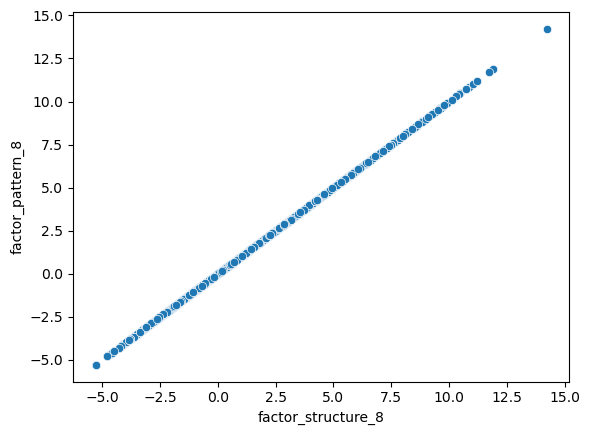

In [42]:
import seaborn as sns
sns.scatterplot(data=answers, x="factor_structure_8", y = "factor_pattern_8")

In [34]:
answers

question,id,1,2,3,4,5,6,7,8,9,...,factor_structure_11,factor_structure_12,factor_structure_13,factor_structure_14,factor_structure_15,factor_structure_16,factor_structure_17,factor_structure_18,factor_structure_19,factor_structure_20
25,28,0.0,1.0,1.0,0.0,3.0,2.0,3.0,2.0,3.0,...,9.588449,4.887000,0.857760,4.897065,-0.819557,2.044687,1.060071,2.170449,1.935475,1.844345
43,46,0.0,0.0,1.0,0.0,3.0,2.0,1.0,2.0,3.0,...,11.519656,8.756139,0.000000,7.243053,-2.224620,2.044687,1.060071,0.804946,0.000000,0.000000
88,95,0.0,0.0,4.0,1.0,4.0,0.0,1.0,1.0,4.0,...,11.070951,8.354591,0.000000,1.711848,-4.839578,3.005138,-1.900729,0.000000,3.134186,2.916116
91,98,1.0,1.0,3.0,3.0,1.0,4.0,3.0,4.0,4.0,...,NaN,NaN,6.587161,NaN,NaN,1.084237,2.798682,NaN,2.089457,1.944078
93,100,0.0,0.0,1.0,1.0,4.0,1.0,3.0,1.0,3.0,...,12.908918,9.742359,0.857760,5.941384,-4.839578,2.253853,-2.714160,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33294,44925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33296,44928,0.0,1.0,2.0,1.0,2.0,3.0,4.0,1.0,4.0,...,10.505801,2.682145,3.868171,4.057836,0.390337,1.293403,-1.788979,0.000000,1.935475,1.844345
33328,44988,0.0,2.0,1.0,2.0,1.0,3.0,4.0,1.0,3.0,...,12.908918,9.742359,0.000000,3.407001,-4.839578,1.835521,-0.185259,4.340898,0.000000,0.000000
33350,45024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.502569,-2.714160,NaN,NaN,NaN
